# Credit Risk Assessment

A credit risk is the risk of default on a debt that may arise from a borrower failing to make required payments. Someone who defaults on their loans can mean a lot of money lost for a financial institute and at the same time, false negatives (i.e. declining a loan when they are capable of repaying the money) can mean money lost from interest. The following is a method for predicting credit risk of a customer. We use German Credit Data stored in the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)

# Data Munging

We need to transform the raw data into another format that is appropriate for analysis.

In [1]:
import pandas as pd

In [2]:
#Read in the csv file that contains the German Credit Data.
credit_risk_df = pd.read_csv('data/german.data', delimiter=' ', 
                            names = ["checkingAccount",
                                     "duration",
                                     "creditHistory",
                                     "purpose",
                                     "amount",
                                     "savingsAccount",
                                     "employed",
                                     "installmentRate",
                                     "gender",
                                     "otherDebtors",
                                     "residentYears",
                                     "property",
                                     "age",
                                     "installmentPlans",
                                     "housing",
                                     "existingCredits",
                                     "job",
                                     "dependents",
                                     "telephone",
                                     "foreign",
                                     "risk"])

In [3]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,purpose,amount,savingsAccount,employed,installmentRate,gender,otherDebtors,...,property,age,installmentPlans,housing,existingCredits,job,dependents,telephone,foreign,risk
0,A11,6,A34,A43,684,A65,A75,4,A93,A101,...,A121,76,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,12974,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,5996,A61,A74,2,A93,A101,...,A121,58,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,1749,A61,A74,2,A93,A103,...,A122,88,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,12431,A61,A73,3,A93,A101,...,A124,24,A143,A153,2,A173,2,A191,A201,2


As you can see, the German credit dataset is quite unreadable. We will need to map each feature value to its coresponding description.

In [4]:
#Ordinal Values have a clear ordering of the variables.
original_ordinal_vals = {"checkingAccount": {"A11": "low", "A12": "medium", "A13": "high", "A14": "none"},
                 "creditHistory": {"A30": "excellent", "A31" : "good", "A32": "okay", "A33": 'bad', "A34": "very bad"},
                 "savingsAccount": {"A61": "low", "A62": "medium", "A63": "high", "A64": "very high", "A65": "none"},
                 "employed": {"A71": "0", "A72": "< 1", "A73": "1-4", "A74": "4-7", "A75": ">= 7"},
                 "job": {"A171": "unemployed/unskilled/non-resident", "A172": "unskilled/resident", "A173": "employed/skilled", "A174": "employed/highly-skilled"}
                }

#Categorical Values do not have an ordering.
original_categorical_vals = {"purpose": {"A40":"car", "A41": "car", "A42":"furniture", "A43": "television", 
                                         "A44": "domestic appliances", "A45": "repairs", "A46": "education/business",
                                         "A48": "education/business", "A49": "education/business", "A410": "other"},
                             "gender": {"A91": "male", "A92": "female", "A93": "male", "A94": "male", "A95": "female"},
                             "otherDebtors": {"A101": "none", "A102": "co-applicant", "A103": "guarantor"},
                             "installmentPlans": {"A141": "yes", "A142": "yes", "A143": "no"},
                             "housing": {"A151": "rent", "A152": "own", "A153": "free"}
                }

credit_risk_df['risk'] = credit_risk_df['risk'].map({1:0,2:1})

#Delete features that will not make a difference to predicting credit risk.
del credit_risk_df['property']
del credit_risk_df['telephone']
del credit_risk_df['foreign']

credit_risk_df.replace(original_ordinal_vals, inplace=True)
credit_risk_df.replace(original_categorical_vals, inplace=True)

#Convert from DM to USD.
credit_risk_df['amount'] = credit_risk_df['amount'].map(lambda x : ((x * 58)/100))

In [5]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,purpose,amount,savingsAccount,employed,installmentRate,gender,otherDebtors,residentYears,age,installmentPlans,housing,existingCredits,job,dependents,risk
0,low,6,very bad,television,396.72,none,>= 7,4,male,none,4,76,no,own,2,employed/skilled,1,0
1,medium,48,okay,television,7524.92,low,1-4,2,female,none,2,22,no,own,1,employed/skilled,1,1
2,none,12,very bad,education/business,3477.68,low,4-7,2,male,none,3,58,no,own,1,unskilled/resident,2,0
3,low,42,okay,furniture,1014.42,low,4-7,2,male,guarantor,4,88,no,free,1,employed/skilled,2,0
4,low,24,bad,car,7209.98,low,1-4,3,male,none,4,24,no,free,2,employed/skilled,2,1


In [6]:
credit_risk_orig_df = credit_risk_df.copy(deep=True)

In [7]:
#Perform label encoding.
def handle_ordinal_values(attribute, categories, df):
    cat_str = attribute + 'Cat'
    df[attribute] = pd.Categorical(df[attribute], categories)
    df[cat_str] = df[attribute].cat.codes

ordinal_mapping = {'checkingAccount':["none","low", "medium", "high"], 
                   'creditHistory': ["very bad", "bad", "okay", "good", "excellent"],
                   'savingsAccount': ["none", "low", "medium", "high", "very high"],
                   'employed': ["0", "< 1", "1-4", "4-7", ">= 7"],
                   'job': ["unemployed/unskilled/non-resident","unskilled/resident","employed/skilled","employed/highly-skilled"]}

for feature, feature_vals in ordinal_mapping.items():
    handle_ordinal_values(feature, feature_vals, credit_risk_df)

In [8]:
#Perform one-hot encoding
credit_risk_df = pd.get_dummies(credit_risk_df, columns=["purpose", "gender", "otherDebtors", "installmentPlans", "housing"])

In [9]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,amount,savingsAccount,employed,installmentRate,residentYears,age,existingCredits,...,gender_female,gender_male,otherDebtors_co-applicant,otherDebtors_guarantor,otherDebtors_none,installmentPlans_no,installmentPlans_yes,housing_free,housing_own,housing_rent
0,low,6,very bad,396.72,none,>= 7,4,4,76,2,...,0,1,0,0,1,1,0,0,1,0
1,medium,48,okay,7524.92,low,1-4,2,2,22,1,...,1,0,0,0,1,1,0,0,1,0
2,none,12,very bad,3477.68,low,4-7,2,3,58,1,...,0,1,0,0,1,1,0,0,1,0
3,low,42,okay,1014.42,low,4-7,2,4,88,1,...,0,1,0,1,0,1,0,1,0,0
4,low,24,bad,7209.98,low,1-4,3,4,24,2,...,0,1,0,0,1,1,0,1,0,0


# Exploratory Analysis

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
credit_risk_orig_df.dtypes

checkingAccount      object
duration              int64
creditHistory        object
purpose              object
amount              float64
savingsAccount       object
employed             object
installmentRate       int64
gender               object
otherDebtors         object
residentYears         int64
age                   int64
installmentPlans     object
housing              object
existingCredits       int64
job                  object
dependents            int64
risk                  int64
dtype: object

In [12]:
#Calculate the averages of the different features and group by risk where 
#0 is good risk and 1 is bad risk. 
credit_risk_orig_df.groupby('risk').mean()

,duration,amount,installmentRate,residentYears,age,existingCredits,dependents
risk,,,,,,,
0,19.207143,2511.4464,2.920000,2.842857,60.957143,1.424286,1.155714
1,24.860000,6705.1364,3.096667,2.850000,36.563333,1.366667,1.153333


In [13]:
#Group by risk and aggregate the top value count for each feature.
credit_risk_orig_df.groupby('risk').agg(lambda x: x.value_counts().index[0])

,checkingAccount,duration,creditHistory,purpose,amount,savingsAccount,employed,installmentRate,gender,otherDebtors,residentYears,age,installmentPlans,housing,existingCredits,job,dependents
risk,,,,,,,,,,,,,,,,,
0,none,12,okay,car,2082.20,low,1-4,4,male,none,4,48,no,own,1,employed/skilled,1
1,low,24,okay,car,8828.76,low,1-4,4,male,none,4,41,no,own,1,employed/skilled,1


In [14]:
credit_risk_df['age'].describe()

count    1000.000000
mean       53.639000
std        22.411447
min        18.000000
25%        36.000000
50%        48.000000
75%        71.000000
max        99.000000
Name: age, dtype: float64

Judging from the averages for each risk group, we notice that people who request for less money and are older are lower risk than those who are 
requesting for more money and are younger in age. So lets use seaborn to plot the data and fit a regression model.

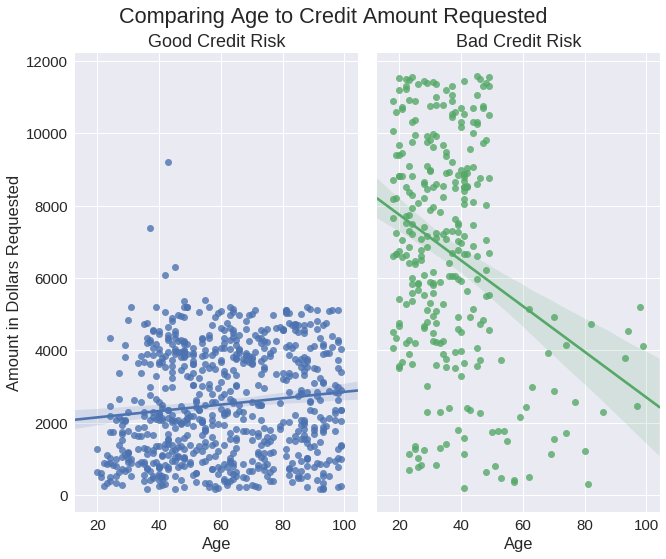

In [15]:
sns.set(font_scale=1.5)
age_vs_amount_plots = sns.lmplot(x='age', y='amount', data=credit_risk_df, hue='risk', col='risk', size=8, aspect=.6)
plt.subplots_adjust(top=0.9)
age_vs_amount_plots.fig.suptitle("Comparing Age to Credit Amount Requested")
age_vs_amount_plots.set_axis_labels("Age", "Amount in Dollars Requested")
titles=['Good Credit Risk', 'Bad Credit Risk']
for ax, title in zip(age_vs_amount_plots.axes.flat, titles):
    ax.set_title(title)

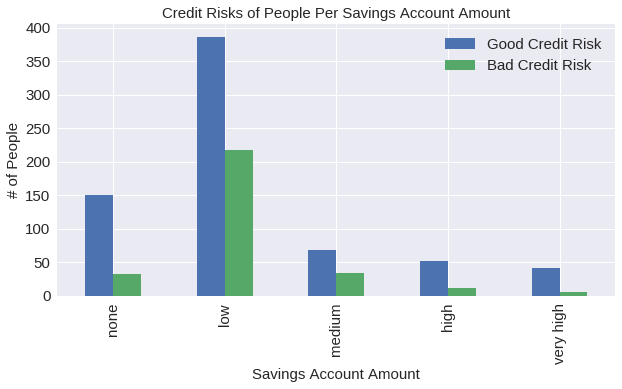

In [16]:
num_risks = credit_risk_df.groupby(['savingsAccount', 'risk']).size()
num_risks_unstacked = num_risks.unstack()
num_risks_unstacked.plot(kind='bar', figsize=(10,5), fontsize=15)
plt.legend(['Good Credit Risk', 'Bad Credit Risk'], fontsize=15)
plt.title("Credit Risks of People Per Savings Account Amount", fontsize=15)
plt.ylabel("# of People", fontsize=15)
plt.xlabel("Savings Account Amount", fontsize=15)

A graph that might be more helpful to understand credit risks of people based on savings account would be showing the different percentages per savings account amount.

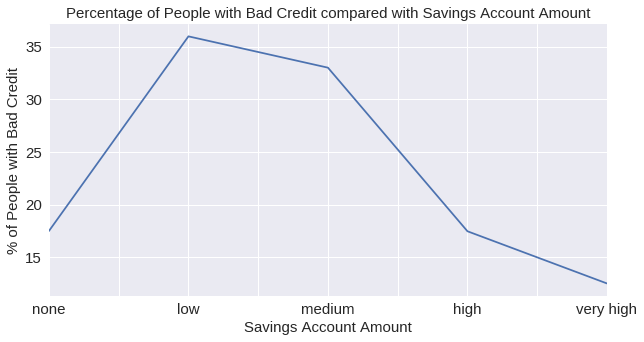

In [17]:
risks_percentages = num_risks.groupby(level=0).apply(lambda x : x / x.sum() * 100).unstack()
risks_percentages[1].plot(kind='line', figsize=(10,5),fontsize=15)
plt.title("Percentage of People with Bad Credit compared with Savings Account Amount", fontsize=15)
plt.ylabel("% of People with Bad Credit", fontsize=15)
plt.xlabel("Savings Account Amount", fontsize=15)

As we can see, there are less people with bad credit who have more money in their savings account.

In [18]:
num_dependents = credit_risk_df.groupby(['dependents','risk']).size().unstack()
num_dependents.columns = ['Good Credit Risk', 'Bad Credit Risk']
num_dependents

,Good Credit Risk,Bad Credit Risk
dependents,,
1,591,254
2,109,46


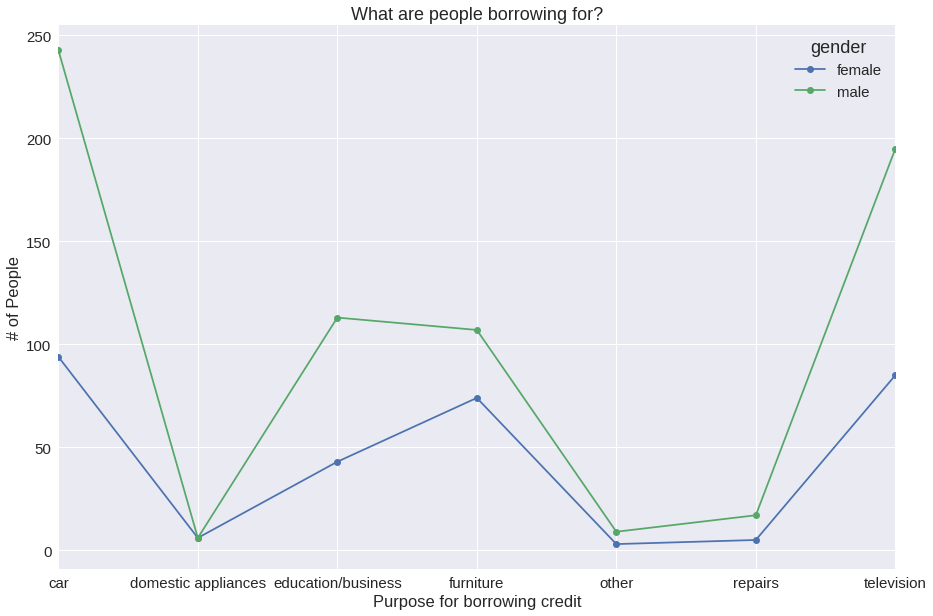

In [19]:
gender_vs_purpose = credit_risk_orig_df.groupby(['purpose', 'gender']).size().unstack()
gender_vs_purpose.plot(kind='line', marker='o', figsize=(15,10))
plt.title("What are people borrowing for?")
plt.ylabel("# of People")
plt.xlabel("Purpose for borrowing credit")

These different visuals help to understand our data better. It is hard to pick out with the human eye all these correlations. Pandas, matplotlib, and seaborn make it incredibly easy to find these underlying patterns.

# Predictive Analysis

For classification models some classic machine learning algorithms that people use are logistic regression and Random Forest. Here we will try out both and pick the model that performs better.

## Logistic Regression

Logistic Regression is nice because it is fast, highly scalable, doesn't require tuning and is easy to regularize. Also, the output of logistic regression is a set of probabilities. It is useful to have probabilities as opposed to the actual class label because we can easily adjust the threshold to label datasets.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [21]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,amount,savingsAccount,employed,installmentRate,residentYears,age,existingCredits,...,gender_female,gender_male,otherDebtors_co-applicant,otherDebtors_guarantor,otherDebtors_none,installmentPlans_no,installmentPlans_yes,housing_free,housing_own,housing_rent
0,low,6,very bad,396.72,none,>= 7,4,4,76,2,...,0,1,0,0,1,1,0,0,1,0
1,medium,48,okay,7524.92,low,1-4,2,2,22,1,...,1,0,0,0,1,1,0,0,1,0
2,none,12,very bad,3477.68,low,4-7,2,3,58,1,...,0,1,0,0,1,1,0,0,1,0
3,low,42,okay,1014.42,low,4-7,2,4,88,1,...,0,1,0,1,0,1,0,1,0,0
4,low,24,bad,7209.98,low,1-4,3,4,24,2,...,0,1,0,0,1,1,0,1,0,0


In [22]:
# Create train and test dataframes. First we are going to drop the 
# categorical variables.
credit_risk_df = credit_risk_df.drop(['checkingAccount', 'creditHistory', 'savingsAccount', 'employed', 'job'], axis=1)

X = credit_risk_df.drop('risk', axis=1)
y = credit_risk_df['risk']

In [23]:
#Create the model.
model = LogisticRegression()
#Use cross validation to prevent overfitting. Here we pick 10 fold cross
#validation. i.e. we take out a set of the data to use for test and 
#leave in the rest for training.
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.26)


Let's try to regularize our logistic regression to make it more generalized. Here, we try using grid search to perform an exhaustive search over the parameter space.

In [24]:
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1','l2']}
clf = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='neg_log_loss')
clf.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [25]:
print(clf.best_score_)
print(clf.best_params_)

-0.334625441335
{'C': 0.001, 'penalty': 'l1'}


In [26]:
model = LogisticRegression(C=.01, penalty='l2')
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.27)


## Random Forest

Random Forest is another popular algorithm for both classification and regression. It requires very little tuning and less prone to overfitting.

Another popular classification algorithm. It is an aggregation of decision trees where each tree is composed of a series of decisions to classify an observation in a dataset.

In [27]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split

model = RFC(n_estimators = 200)
scores = cross_val_score(model, X,y, cv=10, scoring='accuracy' )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.25)


We are now going to fit the model on our training set and then see how well the random forest performs on our test set. The results are show in the cross-tabulation.

In [28]:
train, test = train_test_split(credit_risk_df, test_size = 0.3)
model.fit(train.loc[:, train.columns != 'risk'], train['risk'])
preds = model.predict(test.loc[:,train.columns !='risk'])
pd.crosstab(index=test['risk'], columns=preds, rownames=['Actual Value'], colnames=['Predictions'])

Predictions,0,1
Actual Value,,
0,202,5
1,20,73


One of the strongest points of random forest is seeing which features work best for each tree. Here we rank the importance of the features in our random forest.

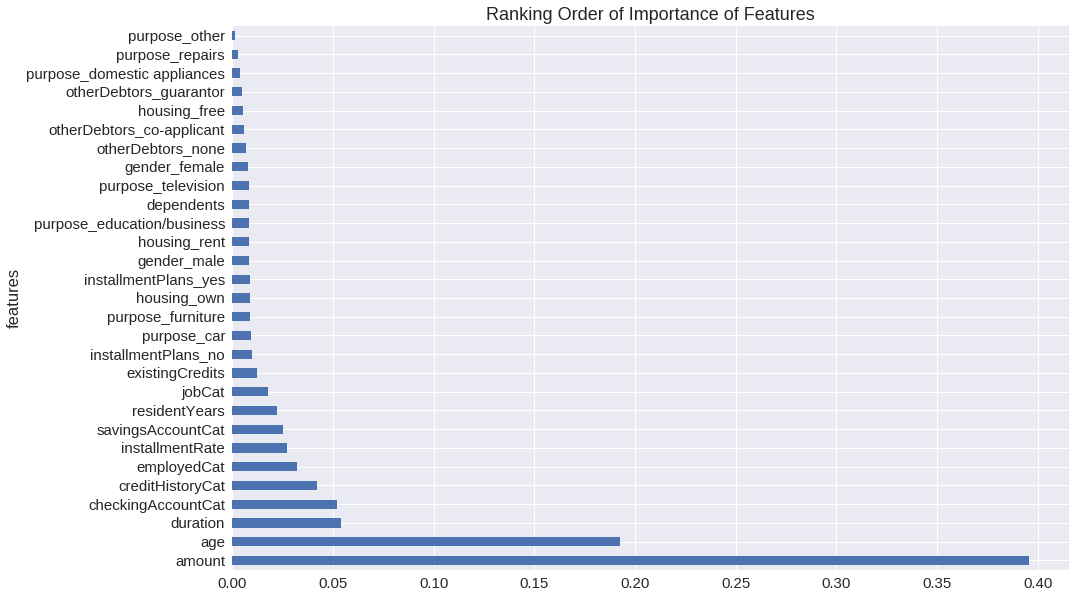

In [29]:
cols = [col for col in train.columns if col not in ['risk']]
importances = pd.DataFrame({'features':cols,'importance_value':model.feature_importances_})
importances = importances.sort_values('importance_value',ascending=False).set_index('features')
importances.plot(figsize=(15,10), kind="barh", legend=False, title="Ranking Order of Importance of Features")

# Potential Customer Scenario

In [30]:
def clean_data(customer):
    for feature, feature_vals in ordinal_mapping.items():
        handle_ordinal_values(feature, feature_vals, customer)
    customer = pd.get_dummies(customer, columns=["purpose", "gender", "otherDebtors", "installmentPlans", "housing"])
    customer = customer.reindex(columns = X.columns, fill_value=0)
    return customer

#New customer info
customer_info = {'checkingAccount': 'medium', 
                 'duration': 6, 
                 'creditHistory': 'okay', 
                 'purpose': 'television', 
                 'amount': 15000,
                 'savingsAccount': 'low', 
                 'employed': '>= 7', 
                 'installmentRate': 2, 
                 'gender': 'female', 
                 'otherDebtors': 'none', 
                 'residentYears': 4, 'age': 25, 
                 'installmentPlans': 'no', 
                 'housing': 'rent', 
                 'existingCredits': 1, 
                 'job': 'employed/skilled', 
                 'dependents': '1'}

perspective_customer = pd.DataFrame(customer_info, index=[0])
perspective_customer_clean = clean_data(perspective_customer)
model.predict(perspective_customer_clean)

array([1])

# Additional Features

* Add Dask
* Add some benchmarks.